In [1]:
import os
import sys
import time
import pickle
import string
from datetime import datetime
from datetime import timedelta
from itertools import chain, cycle
import collections
from pprint import pprint
from io import StringIO
import pathlib
import sqlite3

import numpy as np
import pandas as pd
import dask.dataframe as dd
from pandas.tools.plotting import parallel_coordinates
import matplotlib.pyplot as plt

#import urllib
#import webbrowser
#import codecs
from bs4 import BeautifulSoup
from xml.dom import minidom
from xml.etree import ElementTree as ET
#from lxml import etree as ET #Supports xpath syntax
import xmltodict 

import nltk
import re
import Levenshtein
import networkx as nx
import json

#from nominatim import Nominatim
#from mpl_toolkits.basemap import Basemap   #http://matplotlib.org/basemap/api/basemap_api.html
from matplotlib import cm
import geopy.geocoders as gg
from geopy.geocoders import Nominatim
import geopandas as gpd
import ipyleaflet
#from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, WMSLayer, Marker, MarkerCluster

import folium
import folium.plugins
#from folium.plugins import MarkerCluster
#from folium.plugins import FastMarkerCluster


#import plotly as py
#import plotly.graph_objs as go
#import plotly.figure_factory as ff

from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display

In [2]:
df_lemmas = pd.read_pickle('./df_lemmas.pkl')

In [14]:
df_lemmas.info(verbose=True, null_counts=True, memory_usage='deep') #, max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416499 entries, 0 to 2416498
Data columns (total 45 columns):
Bundesland               1316889 non-null object
Bundesland_idno          1316889 non-null object
Gemeinde                 1198447 non-null object
Großregion               1296722 non-null object
Großregion_idno          1225463 non-null object
Kleinregion              1286463 non-null object
Kleinregion_idno         1209145 non-null object
Ort                      1198447 non-null object
Ort_idno                 1198447 non-null object
archiv                   2416419 non-null object
bibl                     1719656 non-null object
certainty                25631 non-null object
cit_def                  461023 non-null object
cit_interp               353677 non-null object
cit_note                 111690 non-null object
cit_pRef                 79913 non-null object
cit_quote                704560 non-null object
cit_re                   113327 non-null object
cit_ref       

In [3]:
df_lemmas.columns

Index(['Bundesland', 'Bundesland_idno', 'Gemeinde', 'Großregion',
       'Großregion_idno', 'Kleinregion', 'Kleinregion_idno', 'Ort', 'Ort_idno',
       'archiv', 'bibl', 'certainty', 'cit_def', 'cit_interp', 'cit_note',
       'cit_pRef', 'cit_quote', 'cit_re', 'cit_ref', 'cit_type', 'date',
       'entry_id', 'etym', 'filename', 'fragebogenNummer',
       'hauptlemma_normalized', 'hauptlemma_orig', 'hauptlemma_unique',
       'nebenlemma_normalized', 'nebenlemma_orig', 'nebenlemma_unique',
       'note_anmerkung', 'note_diverse', 'note_notabene', 'orig_placeName',
       'paragraph', 'placeName_id', 'pos', 'quelle', 'quelleBearbeitet',
       'seite', 'simple_placeName', 'tustep', 'usg_corresp', 'verweise'],
      dtype='object')

In [4]:
df_lemmas.head()

,Bundesland,Bundesland_idno,Gemeinde,Großregion,Großregion_idno,Kleinregion,Kleinregion_idno,Ort,Ort_idno,archiv,...,paragraph,placeName_id,pos,quelle,quelleBearbeitet,seite,simple_placeName,tustep,usg_corresp,verweise
0,None,None,None,None,None,None,None,None,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",...,None,None,Subst,Egger Gl.,"{1B,1C} hist. TirWeistGl.",30,None,"(diaun,)",None,None
1,None,None,None,None,None,None,None,None,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",...,None,None,Subst,Schneider Tir.(1965),"{1B,1C:X} Etym.^@ SCHNEIDER· (1963)",601,Chur,"(diaun,)",None,None
2,None,None,None,None,None,None,None,None,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",...,None,None,Subst,Tir.Wb.,"{1B,1C} Tir. TirWb.(1955-1956)","1,1293,337, f337^#3.4 = f.",Chur,"(diaun,)",None,None
3,None,None,None,None,None,None,None,None,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",...,None,None,Interj,Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,None,"(tib,)",None,None
4,None,None,None,None,None,None,None,None,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",...,None,None,Interj,Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,None,"(tib,)",None,None


In [32]:
entry_info = ['filename', 'entry_id']

regions_info = ['Bundesland', 
                'Bundesland_idno', 
                'Gemeinde', 
                #'Gemeinde_idno',
                'Großregion', 
                'Großregion_idno', 
                'Kleinregion', 
                'Kleinregion_idno',
                'Ort', 
                'Ort_idno',
                'simple_placeName',
                'orig_placeName',
                'placeName_id', 
                'usg_corresp',]

lemmas_info = ['date',
               'hauptlemma_normalized', 
               'hauptlemma_orig', 
               'hauptlemma_unique',
               'nebenlemma_normalized',
               'nebenlemma_orig', 
               'nebenlemma_unique', 
               'tustep',
               'etym', 
               'pos',]

ref_info = ['verweise',
            'archiv',
            'quelle',
            'quelleBearbeitet', 
            'seite', 
            'fragebogenNummer', 
            'paragraph', 
            'bibl',]

cit_info = ['cit_def',
            'cit_interp',
            'cit_note',
            'cit_pRef',
            'cit_quote',
            'cit_re',
            'cit_ref',
            'cit_type', 
            'certainty',]

note_info = ['note_anmerkung',
             'note_diverse',
             'note_notabene',]

### Questions for the uncertaities paper

#### 1) number of entries

In [11]:
print('There are {:,} entries in the TEI/XML files'.format(len(df_lemmas)))

There are 2,416,499 entries in the TEI/XML files


#### 2) number of headwords

In [13]:
# original mainlemmas
print('There are {:,} original mainlemmas in the TEI/XML files'.format(len(df_lemmas.hauptlemma_unique.dropna())))

There are 985,853 original mainlemmas in the TEI/XML files


In [19]:
# original nebenlemma
print('There are {:,} original nebenlemma in the TEI/XML files'.format(len(df_lemmas.nebenlemma_orig.dropna())))

There are 112,309 original nebenlemma in the TEI/XML files


In [17]:
# normalized mainlemmas
print('There are {:,} normalized mainlemmas in the TEI/XML files'.format(len(df_lemmas.hauptlemma_normalized.dropna())))

There are 1,314,740 normalized mainlemmas in the TEI/XML files


In [18]:
# normalized nebenlemma
print('There are {:,} normalized nebenlemma in the TEI/XML files'.format(len(df_lemmas.nebenlemma_normalized.dropna())))

There are 112,236 normalized nebenlemma in the TEI/XML files


Number of entries without any lemma

In [40]:
no_haupt = list(set(df_lemmas.index) \
                - set(list(df_lemmas.hauptlemma_unique.dropna().index) \
                + list(df_lemmas.hauptlemma_normalized.dropna().index) \
                + list(df_lemmas.hauptlemma_orig.dropna().index) \
                + list(df_lemmas.nebenlemma_unique.dropna().index) \
                + list(df_lemmas.nebenlemma_normalized.dropna().index) \
                + list(df_lemmas.nebenlemma_orig.dropna().index)))

In [45]:
#Number of entries without any lemma
print('There are {:,} entries with no lemma information in the TEI/XML files'.format(len(df_lemmas.iloc[no_haupt])))

There are 115,270 entries with no lemma information in the TEI/XML files


In [42]:
df_lemmas.iloc[no_haupt][lemmas_info]

,date,hauptlemma_normalized,hauptlemma_orig,hauptlemma_unique,nebenlemma_normalized,nebenlemma_orig,nebenlemma_unique,tustep,etym,pos
1310720,None,None,None,None,None,None,None,"(F-)asa, Fâsan, Fâsal)",None,None
1572867,None,None,None,None,None,None,None,"(ß-age, s-;egA)",None,None
1572872,None,None,None,None,None,None,None,"(sôg,)","(ahd., saga)",None
2097160,None,None,None,None,None,None,None,None,None,None
2097161,None,None,None,None,None,None,None,None,None,None
2097164,None,None,None,None,None,None,None,"(Schab,)",None,None
786448,None,None,None,None,None,None,None,None,"(Schm.II 886,823,)",None
1310737,None,None,None,None,None,None,None,"(n~adl,)",None,None
786450,None,None,None,None,None,None,None,"(Z/üi¡la,)",None,None
1310738,None,None,None,None,None,None,None,"(nei~ dl,)",None,None


Examining one of the entries with no lemmas

In [67]:
chosen = 0
df_lemmas.iloc[no_haupt][['filename', 'entry_id']].iloc[chosen]

filename    ./TEI-XML-2018/bel_m-tei-02/m612_qdb-TEI-02.xml
entry_id                                  m612_qdb-d1e72628
Name: 1310720, dtype: object

In [68]:
df_lemmas.iloc[no_haupt][['filename']].iloc[0].values[chosen]

'./TEI-XML-2018/bel_m-tei-02/m612_qdb-TEI-02.xml'

In [69]:
xmlfile = df_lemmas.iloc[no_haupt][['filename']].iloc[chosen].values[0]
bs = BeautifulSoup(open(xmlfile, encoding="utf8"), 'xml')
root = ET.parse(xmlfile).getroot()

In [74]:
for elem in root.iter('{http://www.tei-c.org/ns/1.0}entry'):
    if elem.attrib['{http://www.w3.org/XML/1998/namespace}id'] == df_lemmas.iloc[no_haupt][['entry_id']].iloc[chosen].values[0]:
        for description in elem.iter():
            print('field and value: ', description.tag, ' --> ', description.text)

field and value:  {http://www.tei-c.org/ns/1.0}entry  -->  
        
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}orth  -->  None
field and value:  {http://www.tei-c.org/ns/1.0}gramGrp  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pos  -->  None
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  F-)asa
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  F-)asa
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  Fâsan
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  Fâsan
field and value:  {http://www.tei-c.org/ns/1.0}gramGrp  -->  
            
field and value:  {http://www.tei-c.org/ns/1.0}gram  -->  [pl]
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  --> 

#### 3) number of entries digitised per data scientist

#### 4) number of headwords per letter

In [ ]:
headwords_idx = set(list(df_lemmas.hauptlemma_unique.dropna().index) \
                + list(df_lemmas.hauptlemma_normalized.dropna().index) \
                + list(df_lemmas.hauptlemma_orig.dropna().index) \
                + list(df_lemmas.nebenlemma_unique.dropna().index) \
                + list(df_lemmas.nebenlemma_normalized.dropna().index) \
                + list(df_lemmas.nebenlemma_orig.dropna().index))

In [90]:
headwords_list = []

for idx in headwords_idx:
    if df_lemmas.hauptlemma_unique.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_unique.iloc[idx])
    elif df_lemmas.hauptlemma_normalized.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_normalized.iloc[idx])
    elif df_lemmas.hauptlemma_orig.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_orig.iloc[idx])
    elif df_lemmas.nebenlemma_unique.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_unique.iloc[idx])
    elif df_lemmas.nebenlemma_normalized.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_normalized.iloc[idx])
    elif df_lemmas.nebenlemma_orig.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_orig.iloc[idx])
        
first_letter = [x[0].upper() for x in headwords_list]

In [128]:
#freq_letters = collections.Counter(first_letter)
#freq_letters.most_common(40)

freq_letters = nltk.FreqDist(first_letter)
freq_letters.most_common(50)

[('S', 373210),
 ('G', 192629),
 ('F', 190978),
 ('H', 189854),
 ('K', 180359),
 ('A', 162978),
 ('W', 122670),
 ('M', 107322),
 ('R', 104967),
 ('L', 101267),
 ('P', 90019),
 ('Z', 85329),
 ('T', 74090),
 ('E', 71092),
 ('D', 61183),
 ('N', 54603),
 ('U', 33973),
 ('J', 21494),
 ('O', 21345),
 ('B', 13719),
 ('Ü', 11380),
 ('I', 9663),
 ('Ë', 7563),
 ('Ê', 5051),
 ('Ô', 3280),
 ('Q', 2768),
 ('Ö', 2668),
 ('Â', 1275),
 ('Ä', 1132),
 ('(', 1056),
 (' ', 943),
 ('←', 389),
 ('V', 324),
 ('[', 123),
 ('C', 98),
 ('Û', 82),
 ('X', 62),
 (':', 59),
 ('^', 36),
 ('Y', 34),
 ('?', 34),
 ('1', 24),
 ('|', 16),
 ('6', 15),
 ('Á', 14),
 ('─', 9),
 ('Å', 9),
 ('2', 7),
 ('\xa0', 6),
 ('†', 3)]

In [129]:
freq_letters.pop('(')
freq_letters.pop(' ')
freq_letters.pop('←')
freq_letters.pop('[')
freq_letters.pop(':')
freq_letters.pop('^')
freq_letters.pop('?')
freq_letters.pop('1')
freq_letters.pop('2')
freq_letters.pop('6')
freq_letters.pop('─')
freq_letters.pop('†')

3

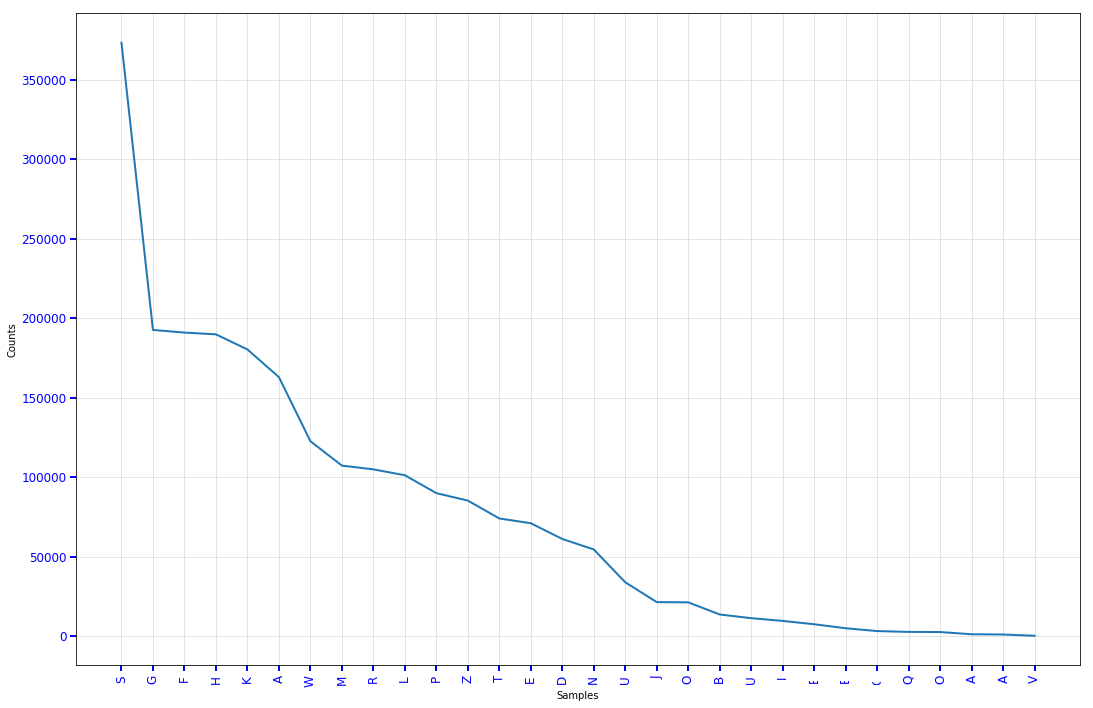

In [131]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=6, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
freq_letters.plot(30,cumulative=False,)

#### 5) number of headwords per location

In [141]:
#df_lemmas.iloc[0]
df_lemmas[regions_info].iloc[6]

Bundesland                     St.
Bundesland_idno                  3
Gemeinde                Lobmingtal
Großregion             sbair.ObSt.
Großregion_idno                3.1
Kleinregion          mittl.obMurt.
Kleinregion_idno              3.1d
Ort                   Kleinlobming
Ort_idno                    3.1d03
simple_placeName              None
orig_placeName      Gr.Lobming St.
placeName_id          sigle:3.1d03
usg_corresp                   None
Name: 6, dtype: object

In [149]:
set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.orig_placeName.dropna().index))

set()

In [150]:
set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.Ort.dropna().index))

set()

In [153]:
print(len(set(df_lemmas.Bundesland.dropna().index)))
print(len(set(df_lemmas.Ort.dropna().index)))
print(len(set(df_lemmas.Bundesland.dropna().index).intersection(set(df_lemmas.Ort.dropna().index))))

1316889
1198447
1198447


In [ ]:
locations_idx = 

In [142]:
locations_list = []

for idx in headwords_idx:
    if df_lemmas.simple_placeName.iloc[idx]:
        locations_list.append(df_lemmas.simple_placeName.iloc[idx])
    elif df_lemmas.Ort.iloc[idx]:
        locations_list.append(df_lemmas.Ort.iloc[idx])

#### 6) average number of entries per headword

#### 7) number of different definitions / meanings

#### 8) number of locations cited

#### 9) number of sources cited

#### 10) number of different people cited

#### 11) number of headwords per person

#### 12) number of entries per person

#### 13) number of concepts per questionnaire

#### 14) number of headwords related to questionnaire

#### 15) number of headwords related to questions

#### 16) number of entries related to questions related to authors of questions/questionnaires

#### 17) number of headwords related to questions related to authors of questions/questionnaires

#### 18) number of locations per person (that is identified)

#### 19) number of female:male collectors

#### 20) average number of entries per questions

#### 21) number of entries related to questionnaires

#### 22) number of entries related to historical sources

#### 23) number of entries related to historical poetic sources

#### 24) number of entries related to "free collections"
#### 25) number of people working on the collection since the start
#### 26) names of people working on the collection since the start
#### 27) number of collectors per questionnaire
#### 28) average number of definitions per entry / paper slip
#### 29) average number of entries per person
#### 30) average number of headwords per person
#### 31) average number of entries per type of location